In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GEMS(Chemical Water Quality)

### Variables


- Dissolved Oxygen (DO)

- Nitrogen (likely multiple: Nitrate, Nitrite, Ammonia)

- Phosphorus

- pH

### Domain Understanding

- Low DO (< 4 mg/L) indicates poor oxygenation which leads to contamination risk.

- High Nitrogen/Phosphorus signify fertilizer/sewage runoff which contributes to eutrophication.

- pH extremes (< 6.5 or > 8.5) indicates corrosiveness/unsuitable for life.



### Feature Engineering

- do_risk = 1 if DO < 4 mg/L else 0
- n_risk = normalized_score(N_total) (log or z-scaled)
- p_risk = normalized_score(P_total)
- ph_deviation = abs(pH - 7)
- Final chemical_risk_score = weighted_sum([do_risk, n_risk, p_risk,
ph_deviation])

### Mercury data

In [52]:
import pandas as pd

In [53]:
mercury_df= pd.read_csv('/home/margaret/Capstone-Project/CleanWatAI/data/GFQA_v2/Mercury.csv', sep=';',encoding='ISO-8859-1', quotechar='"',  low_memory=False)

mercury_df.head()


,GEMS.Station.Number,Sample.Date,Sample.Time,Depth,Parameter.Code,Analysis.Method.Code,Value.Flags,Value,Unit,Data.Quality
0,ARG00014,2011-09-06,11:30,0.3,Hg-Dis,0,<,0.040,µg/l,Fair
1,ARG00014,2011-09-06,11:30,0.3,Hg-Tot,0,<,0.040,µg/l,Fair
2,ARG00014,2012-03-14,12:20,0.3,Hg-Dis,0,NaN,0.044,µg/l,Fair
3,ARG00014,2012-03-14,12:20,0.3,Hg-Tot,0,NaN,0.348,µg/l,Fair
4,ARG00014,2012-06-06,13:20,0.3,Hg-Dis,0,<,0.040,µg/l,Fair


### Data cleaning and exploration

In [54]:
mercury_df.info()  #summary of the data types and nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229612 entries, 0 to 229611
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   GEMS.Station.Number   229612 non-null  object 
 1   Sample.Date           229612 non-null  object 
 2   Sample.Time           229612 non-null  object 
 3   Depth                 229612 non-null  float64
 4   Parameter.Code        229612 non-null  object 
 5   Analysis.Method.Code  229612 non-null  object 
 6   Value.Flags           121229 non-null  object 
 7   Value                 229612 non-null  float64
 8   Unit                  229612 non-null  object 
 9   Data.Quality          229612 non-null  object 
dtypes: float64(2), object(8)
memory usage: 17.5+ MB


In [55]:
mercury_df.describe() ##checking summary stastics

,Depth,Value
count,229612.000000,229612.000000
mean,0.480535,4.890419
std,5.924055,123.446453
min,0.000000,0.000000
25%,0.300000,0.020000
50%,0.300000,0.090000
75%,0.300000,0.100000
max,350.000000,22000.000000


In [56]:
mercury_df.isnull().sum()


GEMS.Station.Number          0
Sample.Date                  0
Sample.Time                  0
Depth                        0
Parameter.Code               0
Analysis.Method.Code         0
Value.Flags             108383
Value                        0
Unit                         0
Data.Quality                 0
dtype: int64

We have 108383 missing values in Value.Flags column

### Handling missing values

In [57]:
mercury_df =mercury_df.dropna(subset=["Value.Flags"])
mercury_df.isnull().sum()



GEMS.Station.Number     0
Sample.Date             0
Sample.Time             0
Depth                   0
Parameter.Code          0
Analysis.Method.Code    0
Value.Flags             0
Value                   0
Unit                    0
Data.Quality            0
dtype: int64

## EDA

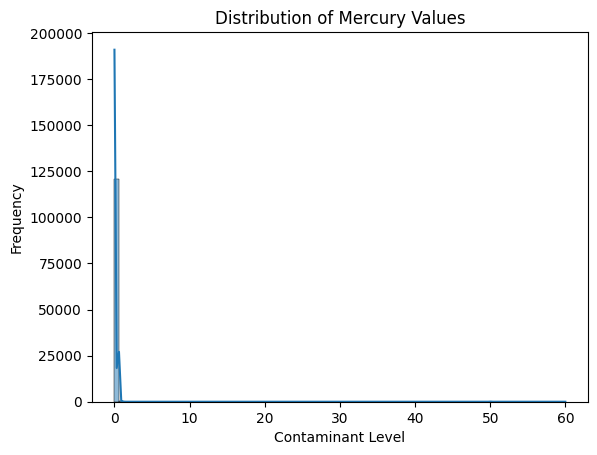

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram 
sns.histplot(mercury_df['Value'], bins=100, kde=True)
plt.title("Distribution of Mercury Values")
plt.xlabel("Contaminant Level")
plt.ylabel("Frequency")
plt.show()


### Looking for the revelant variables

In [59]:
import os

In [61]:
folder_path = '/home/margaret/Capstone-Project/CleanWatAI/data/GFQA_v2'
gems_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

for file in gems_files:
    try:
        df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')
        unique_params = df['Parameter.Code'].unique()
        print(f"{file} has parameters: {unique_params}")
    except Exception as e:
        print(f"❌ Error reading {file}: {e}")


Platinum.csv has parameters: ['Pt-Tot' 'Pt-Ext' 'Pt-Dis']
Pharmaceuticals.csv has parameters: ['SMX' 'TMP' 'AZITHROMYCIN' 'DICLOFENAC' 'ERYTHROMYCIN' 'ATENOLOL'
 'BEZAFIBRATE' 'CARBAMAZEPINE' 'NAPROXEN' 'IBUPROFEN']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Optical.csv has parameters: ['TURB' 'TRANS' 'COL-True' 'COL-App' 'A340']
Boron.csv has parameters: ['B-Dis' 'B-Tot' 'B-Ext']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Pesticides_E_to_L.csv has parameters: ['ISOPROTURON' 'ISODRIN' 'LINURON' 'HEPTACHLOREPOX' 'ETHOFUMESATE'
 'LENACIL' 'FENITROTHION' 'IOXYNIL' 'GLYPHOSATE' 'FENTHION' 'FLUFENACET'
 'GUTHION' 'HEXAZINONE' 'IMIDACLOPRID' 'ETHALFLURALIN' 'IMAZETHAPYR'
 'FENOXAPROP-ETHYL' 'FLUMETSULAM' 'FOMESAFEN' 'FORAMSULFURON'
 'GLUFOSINATE' 'IMAZAMOX' 'IMAZAPHYR' 'FLONICAMID' 'FLUPYRADIFURONE'
 'FLUDIOXONIL' 'ETHION' 'EPOXICONAZOLE' 'FENPROPIMORPH' 'FLUQUINCONAZOLE'
 'HCCPD' 'FLUTRIAFOL' 'FLURTAMONE' 'IPRODIONE' 'FIPRONIL' 'IMAZALIL'
 'HALOXYFOP-METHYL']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Electrical_Conductance.csv has parameters: ['EC']
Gallium.csv has parameters: ['Ga-Ext' 'Ga-Tot' 'Ga-Dis']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Temperature.csv has parameters: ['TEMP' 'TEMP-Air']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Calcium.csv has parameters: ['Ca-Dis' 'Ca-Tot' 'Ca-Ext']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Arsenic.csv has parameters: ['As-Dis' 'As-Tot' 'As-Sus']
Vanadium.csv has parameters: ['V-Tot' 'V-Dis' 'V-Ext']
Cobalt.csv has parameters: ['Co-Dis' 'Co-Ext' 'Co-Tot' 'Co-Sus']
Tin.csv has parameters: ['Sn-Tot' 'Sn-Ext' 'Sn-Dis']
Strontium.csv has parameters: ['Sr-Tot' 'Sr-Ext' 'Sr-Dis']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Potassium.csv has parameters: ['K-Dis' 'K-Tot' 'K-Ext']
Selenium.csv has parameters: ['Se-Dis' 'Se-Tot' 'Se-Ext']
Antimony.csv has parameters: ['Sb-Tot' 'Sb-Ext' 'Sb-Dis']
Phenyl.csv has parameters: ['4TOTPHL' 'CLPHENOL' '24DCP' 'PHLH' 'PHLHs' 'BIPHENYL' '26DCPHL' 'TCS'
 '4NPHENOL' '4CMPHL' '4BPPE' 'NITROBENZENE' 'BENZIDINE' 'HYDRAZOBENZENE'
 '2NITROPHENOL' '23DCP' '24DNP']
Bismuth.csv has parameters: ['Bi-Tot' 'Bi-Ext' 'Bi-Dis']
Aluminium.csv has parameters: ['Al-Tot' 'Al-Dis' 'Al-Ext']
Fluoride.csv has parameters: ['F-Tot' 'F-Dis']
Molybdenum.csv has parameters: ['Mo-Tot' 'Mo-Ext' 'Mo-Dis']
Zinc.csv has parameters: ['Zn-Dis' 'Zn-Tot' 'Zn-Ext' 'Zn-Sus']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Surfactant.csv has parameters: ['4NNPHL' '4NNPHLBRA' '4OPHLH' 'DETERGENTS' 'MBAS']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Magnesium.csv has parameters: ['Mg-Dis' 'Mg-Tot' 'Mg-Ext' 'Mg-Sus']
Flux.csv has parameters: ['Q-Inst']
PFAS.csv has parameters: ['PFOS' 'PFOA']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Oxidized_Nitrogen.csv has parameters: ['NOxN' 'NO2N' 'NO3N']
Phytoplankton.csv has parameters: ['Phyt-B']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Alkalinity.csv has parameters: ['Alk-Tot' 'Alk-Phen']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Chloride.csv has parameters: ['Cl-Tot' 'Cl-Dis']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Carbon.csv has parameters: ['DOC' 'TOC' 'DIC' 'TIC' 'CO3' 'DC' 'POC' 'TC']
Iron.csv has parameters: ['Fe-Dis' 'Fe-Tot' 'Fe-Ext']
Thallium.csv has parameters: ['Tl-Tot' 'Tl-Dis']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Hardness.csv has parameters: ['H-T' 'H-NC' 'H-Ca' 'H-Mg']
Cerium.csv has parameters: ['Ce-Tot' 'Ce-Ext' 'Ce-Dis']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Other_Nitrogen.csv has parameters: ['NH4N' 'NH3N' 'DKN' 'TN' 'TKN' 'TDN' 'TON' 'PN' 'PON' 'DIN' 'TIN' 'DON']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Volatile_Organic_Compounds.csv has parameters: ['BENZENE' 'EDC' 'MECL' '124TCBZ' 'TCB-Tot' '123TCBZ' '135TCBZ' 'CCl4'
 'PCE' 'TCE' 'TOLH' 'XYLTOT' '111TCA' 'ETBZ' '112TCA' 'MTBE' 'CBZH'
 'DETPTHAL8' 'DMP' 'IPBZ' 'MDCB' 'MPXYLS' 'ODCB' 'OXYL' 'PDCB' 'STYRENE'
 'VCM' '11DCA' '12DCPA' '2CT' 'DIBTPTHAL8' 'MXYL' 'PXYL' '24DNT' 'MUSKXYL'
 'TCFMA' 'TCACETICACID' 'DCDFMA' 'ACRYLONITRILE' '2CVE'
 'CL-ISOPROPYLETHER' 'DCEE' 'DEHA' 'HEXACHLORETHANE' 'NDMA' 'NDPA' 'NDPHA'
 '26DNT']
Hydroxide.csv has parameters: ['OH']
Bromine.csv has parameters: ['Br-Tot' 'Br-Dis' 'Br2-Dis']
Caesium.csv has parameters: ['Cs-Tot' 'Cs-Ext' 'Cs-Dis']
Lead.csv has parameters: ['Pb-Dis' 'Pb-Tot' 'Pb-Ext' 'Pb-Sus']
Manganese.csv has parameters: ['Mn-Dis' 'Mn-Tot' 'Mn-Ext']
Silver.csv has parameters: ['Ag-Dis' 'Ag-Tot' 'Ag-Ext']
Berillium.csv has parameters: ['Be-Tot' 'Be-Ext' 'Be-Dis']
Lithium.csv has parameters: ['Li-Ext' 'Li-Tot' 'Li-Dis' 'Li-Sus']
Pigment.csv has parameters: ['Chl-a']
❌ Error reading GEMStat_methods_

/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Chromium.csv has parameters: ['Cr-Dis' 'Cr-Tot' 'Cr-Ext' 'Cr-VI']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Dissolved_Gas.csv has parameters: ['O2-Dis' 'O2-Dis-Sat' 'CO2' 'H2S']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Mercury.csv has parameters: ['Hg-Dis' 'Hg-Tot' 'Hg-Ext' 'Hg-Sus']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Pesticide_A_B.csv has parameters: ['ALACHLOR' 'ATRAZINE' 'ACETAMIPRID' 'AMETRYN' 'ATRAZINEDESET' 'BENTAZON'
 'BROMACIL' 'BAM' 'BROMOXYNIL' 'AMPA' 'ACLONIFEN' 'AZINPHOS-ETHYL'
 'BIFENOX' 'BENZOYLPROP-ETHYL' 'BUTYLATE' 'ACIFLUORFEN' 'ALDICARB'
 'BENSULFURON' 'BENDIOCARB' 'ACETOCHLOR' 'AZOXYSTROBIN' 'ACROLEIN'
 'BIFENTHRIN' 'ALPHACYPERMETHRIN' 'ATTAINA']
Nickel.csv has parameters: ['Ni-Dis' 'Ni-Tot' 'Ni-Ext' 'Ni-Sus']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Indicator_Organism.csv has parameters: ['FECALCOLI' 'ECOLI' 'TOTCOLI' 'FECALSTREP' 'ENTCOCC' 'TOTMESO']
Silicon.csv has parameters: ['SiO2-Tot' 'SiO2-Dis' 'Si-Dis' 'Si-Ext' 'SiO2-Rea' 'Si-Tot']
❌ Error reading GEMStat_station_metadata.csv: 'Parameter.Code'


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Halocarbon.csv has parameters: ['TCMA' 'BDCMA' 'BROMOFORM' 'CHLORODIBROMOMETHANE' 'cis-DCE' 'DCE'
 'trans-DCE' '11DCE' '1112TTCETA' '1122TTCETA' 'METHYLBROMIDE'
 'CHLOROBROMOMETHANE' 'METHYLCHLORIDE' 'DCB' 'THMs']
Lanthanum.csv has parameters: ['La-Ext' 'La-Tot' 'La-Dis']
Salinity.csv has parameters: ['Sal']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Persistent_Organic_Pesticides.csv has parameters: ['BHC-gamma' 'SCCP' 'ALDRIN' 'DIELDRIN' 'ENDRIN' 'PCP' 'PECBZ' 'BHC' 'HCB'
 'ENDOSULFAN' 'BHC-alpha' 'BHC-beta' 'ENDOSULFANI' 'PCB' 'DDT' 'PCB-101'
 'PCB-138' 'PCB-153' 'PCB-180' 'PCB-28' 'PCB-52' 'HEPTACHLOR' 'PCB-118'
 'BHC-delta' 'CHLORDANE' 'ENDOSULFANII' 'BHC-epsilon' 'CNONACHLOR' 'MIREX'
 'TNONACHLOR' 'DECABDE' 'HeptaBDE' 'HexaBDE' 'OctaBDE' 'PentaBDE'
 'TetraBDE' 'PBDE-Sum' 'KEPONE' '123TCPA' 'PCB-194' 'TOXAPHENE' 'PCN']
Rubidium.csv has parameters: ['Rb-Ext' 'Rb-Tot' 'Rb-Dis']
❌ Error reading GEMStat_parameter_metadata.csv: 'Parameter.Code'


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Sulfur.csv has parameters: ['SO4-Tot' 'SO4-Dis' 'S-Tot' 'S-Sus' 'S-Dis']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Sodium.csv has parameters: ['Na-Dis' 'Na-Tot' 'Na-Ext' 'SAR']
Titanium.csv has parameters: ['Ti-Tot' 'Ti-Ext' 'Ti-Dis']
Uranium.csv has parameters: ['U-Dis' 'U-Tot' 'U-Ext']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Water.csv has parameters: ['TDS' 'TS' 'TSS' 'FSS' 'FS' 'VS' 'VSS' 'VDS' 'FDS']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Pesticides_S_to_Z.csv has parameters: ['SIMAZINE' 'THIACLOPRID' 'TMX' 'TRIALLATE' 'TRIFLURALIN' 'TBT-Cation'
 'TERBUTHYLAZINE' 'TERBUTRYN' '245T' 'SEBUTHYLAZINE' 'TCP'
 'TERBUTYLAZINE-DESETHYL' 'TRICLOPYR' '245TCPHL' '245TP' '246TCPHL'
 'TEBUCONAZOLE' 'THIFENSULFURON' 'TRIBENURON' 'TCMTB' 'TEBUTHIURON'
 'TERBUFOS' 'TRIFLOXYSTROBIN' 'STIROFOS' 'SPIRODICLOFEN' 'SPIROTETRAMAT'
 'SULFOXAFLOR' 'SULCOTRIONE' 'TRICYCLAZOLE']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Pesticides_C_D.csv has parameters: ['DCMU' 'CLOTHIANIDINE' 'CHLORPYRIFOS' 'DICHLORVOS' 'DIMOXYSTROBIN'
 'DIMETHOATE' 'CHLORFENVINPHOS' '44DDT' '24DDT' '44DDD' '44DDE'
 'DIMPYLATE' 'DINOSEB' '24D' '24DB' 'CARBOFURAN' 'CYANAZINE' 'DCBN'
 'DEISOPROPYLATRAZINE' '24DP' 'CHLORIDAZON' '36DCP' 'DIFLUFENICAN' '24DDE'
 'CHLORTOLURON' 'ACHLORDANE' 'BCHLORDANE' 'CARBETAMIDE' 'CP' 'CYBUTRYNE'
 'DICAMBA' 'DIMETHENAMID' 'DIMETHOMORPH' '24DDD' 'DICLOFOP-METHYL'
 'GCHLORDANE' 'CARBARYL' 'CHLORIMURON' 'CHLORSULFURON' 'CLOMAZONE'
 'DINOTEFURAN' 'CAPTAFOL' 'CAPTAN' 'CHLOROXURON' 'CYHALOTHRIN'
 'DISULFOTON' 'DYPHONATE' 'CHLORANTRANILIPROLE' 'CPSM' 'DIMETHACHLOR'
 'DSM' 'DDD' 'DESMETRYN' 'DALAPON' 'DBCP' 'DNOC' 'DEET' 'CYPROCONAZOLE'
 'LAMBDA-CYHALOTHRIN']
Tungsten.csv has parameters: ['W-Tot' 'W-Ext' 'W-Dis']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


PAH.csv has parameters: ['BAP' 'BZBFLA' 'BZGHIPYL' 'BZKFLA' 'FLAH' 'IDN123CDPYR' 'ANTHRACENE'
 'NPTH' 'ANTH' 'ANTL' 'BZAATR' 'CRYH' 'DBA' 'FLRH' 'PHNH' 'PYRENE' 'PAH'
 'BTBZLPTHAL8' 'DICOFOL' 'BEP' 'INDENE' 'PYL' 'TETRALIN' '1MNPT' '2MNPT'
 'MCA' 'DBA-Sus' 'NAPHTHOL' 'BENZATHRENE' '2CLNAPHTHALENE']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Phosphorus.csv has parameters: ['DRP' 'DIP' 'TDP' 'TP' 'TIP' 'TRP' 'TPP']
Cadmium.csv has parameters: ['Cd-Dis' 'Cd-Tot' 'Cd-Ext' 'Cd-Sus']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Bicarbonate.csv has parameters: ['HCO3']
Yttrium.csv has parameters: ['Y-Tot' 'Y-Ext' 'Y-Dis']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Pesticides_M_to_R.csv has parameters: ['METHIOCARB' 'MCPA' 'MCPPACID' 'QUINOXYFEN' 'MCPB' 'PROMETRYN'
 'METAMITRON' 'METAPHOS' 'METOLACHOR' 'METRIBUZIN' 'PARATHION' 'PROPAZINE'
 'PENDIMETHALIN' 'MALATHION' 'METHOMYL' 'METSULFURON-METHYL' 'MBC'
 'METAZACHLOR' 'METHABENZTHIAZURON' 'METOBROMURON' 'MEVINPHOS'
 'MONOLINURON' 'MXCHLOR' 'PIRIMICARB' 'PICLORAM' 'METALAXYL'
 'NICOSULFURON' 'OXAMYL' 'PRIMISULFURON' 'PROSULFURON' 'RIMSULFURON'
 'METHIDATHION' 'MYCLOBUTANIL' 'NAPROPAMIDE' 'PHORATE' 'PHOSALONE'
 'PROPOXUR' 'PYRACLOSTROBIN' 'PHOSMET' '2MPHL' 'OMETHOATE' 'PECNBZ'
 'PIRIMIPHOSMETHYL' 'PROPICONAZOLE' 'PRONAMIDE' 'METHAMIDOPHOS'
 '1CLNAPHTHALENE' 'PICOLINAFEN' 'METHOXYFENOZIDE' 'PYRIMETHANIL'
 'PROTHIOCONAZOLE' 'PERMETHRIN']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


pH.csv has parameters: ['pH']
Organic.csv has parameters: ['HC-Tot' 'DEHP' 'TPHC' 'CARBAZOLE' '34DCA' 'ONCB' 'PNCB' 'OG' 'IP' 'AOX']
Barium.csv has parameters: ['Ba-Tot' 'Ba-Ext' 'Ba-Dis']
Niobium.csv has parameters: ['Nb-Tot' 'Nb-Ext' 'Nb-Dis']


/tmp/ipykernel_23640/3012381163.py:6: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file), sep=';', encoding='latin1')


Oxygen_Demand.csv has parameters: ['BOD' 'COD' 'PV']
Copper.csv has parameters: ['Cu-Dis' 'Cu-Tot' 'Cu-Ext' 'Cu-Sus']


### Modeling

In [62]:
df = pd.read_csv('/home/margaret/Capstone-Project/CleanWatAI/data/processed/gems.csv')
df.head()

,GEMS.Station.Number,Sample.Date,pH,NO2N,NO3N,DRP
0,ARG00003,2018-11-15,7.16,0.01000,0.05,1.30000
1,ARG00003,2019-05-08,7.10,0.01000,0.10,0.05000
2,ARG00003,2019-11-06,7.47,0.01000,0.05,0.05000
3,ARG00003,2020-02-26,8.15,0.01000,0.11,0.70000
4,ARG00003,2020-11-04,8.10,0.00075,0.23,0.00165


In [63]:
df.info

<bound method DataFrame.info of       GEMS.Station.Number Sample.Date    pH     NO2N    NO3N      DRP
0                ARG00003  2018-11-15  7.16  0.01000  0.0500  1.30000
1                ARG00003  2019-05-08  7.10  0.01000  0.1000  0.05000
2                ARG00003  2019-11-06  7.47  0.01000  0.0500  0.05000
3                ARG00003  2020-02-26  8.15  0.01000  0.1100  0.70000
4                ARG00003  2020-11-04  8.10  0.00075  0.2300  0.00165
...                   ...         ...   ...      ...     ...      ...
39430            USA00532  2005-06-07  8.10  0.01400  0.8625  0.00300
39431            USA00532  2005-06-24  8.00  0.02200  0.8495  0.00300
39432            USA00532  2005-07-13  8.00  0.03200  0.8220  0.00700
39433            USA00532  2005-08-09  8.10  0.02600  0.5350  0.00300
39434            USA00532  2005-09-22  6.20  0.11600  0.8135  0.01100

[39435 rows x 6 columns]>

In [64]:
df.describe()

,pH,NO2N,NO3N,DRP
count,39435.000000,39435.000000,39435.000000,39435.000000
mean,7.956184,0.067340,1.488265,0.174718
std,1.475497,0.300511,3.561116,0.665418
min,2.000000,0.000000,0.000000,0.000000
25%,7.680000,0.000000,0.180000,0.010334
50%,8.010000,0.010000,0.504432,0.041332
75%,8.300000,0.030000,1.370000,0.124008
max,282.700000,9.660000,145.080000,40.000000


In [65]:
print(df.columns.tolist())

['GEMS.Station.Number', 'Sample.Date', 'pH', 'NO2N', 'NO3N', 'DRP']


In [66]:
# Basic thresholds (for demonstration; use real thresholds if known)
df['pH_flag'] = df['pH'].between(6.5, 8.5)
df['NO3N_flag'] = df['NO3N'] <= 10  # mg/L nitrate-N
df['NO2N_flag'] = df['NO2N'] <= 1   # conservative nitrite
df['DRP_flag'] = df['DRP'] <= 0.1   # threshold for phosphorus

# Water is safe only if all are True
df['Safe'] = (df['pH_flag'] & df['NO3N_flag'] & df['NO2N_flag'] & df['DRP_flag']).astype(int)


In [67]:
print(df.columns.tolist())


['GEMS.Station.Number', 'Sample.Date', 'pH', 'NO2N', 'NO3N', 'DRP', 'pH_flag', 'NO3N_flag', 'NO2N_flag', 'DRP_flag', 'Safe']


In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [69]:
X = df[['pH', 'NO3N', 'NO2N', 'DRP']]
y = df['Safe']


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [71]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [72]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)
print("Training complete")
y_pred = logreg.predict(X_test_scaled)


Training complete


In [73]:
print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.77      0.84      2971
           1       0.88      0.96      0.92      4916

    accuracy                           0.89      7887
   macro avg       0.90      0.87      0.88      7887
weighted avg       0.89      0.89      0.89      7887



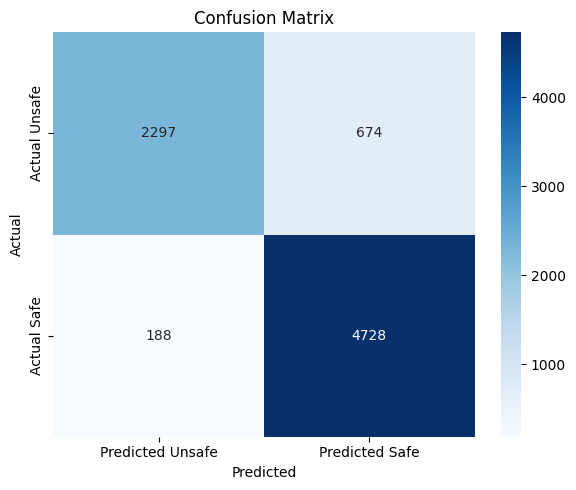

In [74]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Predicted Unsafe", "Predicted Safe"],
            yticklabels=["Actual Unsafe", "Actual Safe"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

 I used a confusion matrix to evaluate how well the model is distinguishing between safe and unsafe water conditions

In [75]:
from sklearn.metrics import roc_auc_score

y_proba = logreg.predict_proba(X_test_scaled)[:, 1]
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


ROC-AUC Score: 0.9343589605952195


A ROC-AUC score of 0.93 is strong hence the model is performing well.

### Random Forest 

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [77]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
#Predicting
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

In [78]:

print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2971
           1       1.00      1.00      1.00      4916

    accuracy                           1.00      7887
   macro avg       1.00      1.00      1.00      7887
weighted avg       1.00      1.00      1.00      7887



### Hyperparameter Tuning

In [79]:
from sklearn.model_selection import GridSearchCV

In [80]:

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

In [81]:

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Best Parameters: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [82]:

y_pred_best = best_rf.predict(X_test)
print("Classification Report (Tuned RF):")
print(classification_report(y_test, y_pred_best))

Classification Report (Tuned RF):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2971
           1       1.00      1.00      1.00      4916

    accuracy                           1.00      7887
   macro avg       1.00      1.00      1.00      7887
weighted avg       1.00      1.00      1.00      7887



While the models performed well using pH, nitrate, nitrite, and phosphorus, the absence of Dissolved Oxygen has contributed to very high accuracy. Including DO could enhance the model’s ability to detect unsafe conditions, especially those related to oxygen depletion in aquatic environments.